---
layout: post
title:  "A machine learning project recipe"
date:   2023-04-05 10:14:54 +0700
categories: MachineLearning
---

# TOC

- [Data preprocessing](#prep)
- [Training and fine-tuning](#train)
- [Monitoring](#monitor)

# Introduction
Let's see how to run a machine learning model from beginning to end: from data preprocessing, model training to model selection and evaluation. Firstly, data comes in many shapes and sizes, hence the preprocess is crucial in helping the algorithm to process and highlight the best findings in those data. Then training a model requires deep understanding of statistics and other mathematical concepts. You need to know when the model overfits and how to use regularization to help with the symptoms. After carefully calibrate different models, you might also need to select between them or to ensemble them together for better purpose. In the end, let's choose the metrics to choose what to display to the world.

# Data preprocessing
Data preprocessing is a critical step. It involves cleaning, transforming, and organizing the data to prepare it for the modeling phase. If you have good data, it greatly helps the performance and accuracy of the model. The preprocessing step can involve several techniques such as handling missing values, removing outliers, data distribution investigation, normalization, categorical variable encoding, and feature engineering. Each technique aims to prepare the data in a way that best suits the machine learning algorithm that will be used for the task at hand. By the end of this recipe, you will have a clear understanding of the importance of data preprocessing and the tools and techniques necessary to prepare your data for machine learning.

Let's first look at the histograms of the numerical variables:

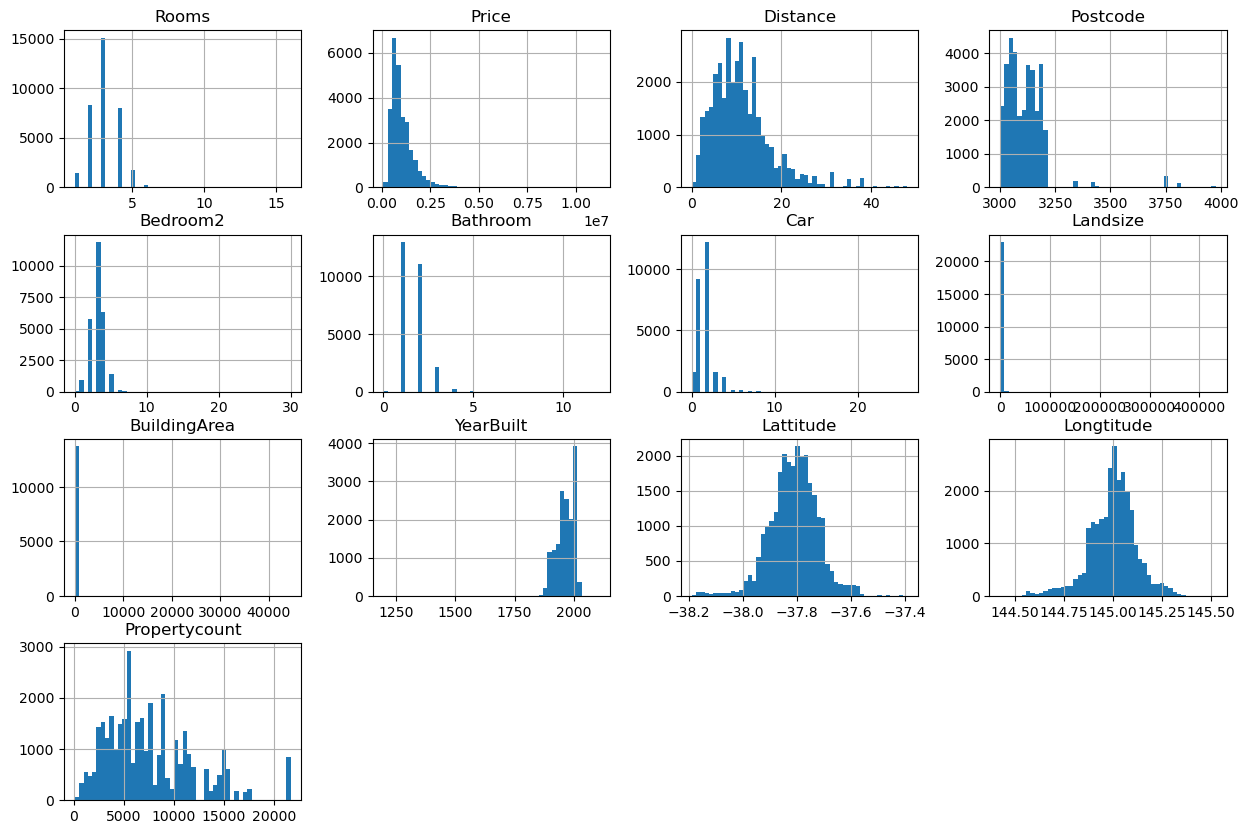

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

housing=pd.read_csv('melbourne-housing/melbourne_housing.csv')
housing.hist(bins=50, figsize=(15, 10))
plt.show()

Notice that the Price is transformed into a range from 0 to 1.25. Price, Distance,.. are skew. Rooms, Price, Bedroom2, Bathroom, Car.. have very long right tails. We can address those issues later. Now let's look into the information to solve the missing values first:

In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [3]:
housing.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


Before anything else, notice that there are 21 attributes: 13 of them are numerical, 8 of them is categorical. We would need to encode those categorical variables later. Now let's address the missing values.

## Missing value
You can see that the Bedroom2 variable has 26640/34867 non null observations, so it has 24% of the data missing which is a lot. Similar to other variables Price, Bathroom, Car,... BuildingArea and YearBuilt both have only half the observations.

There are different ways to handle missing data: to remove the attribute (remove total bedrooms variable altogether), remove the 24% rows of those missing data, or to fill them in (impute). For imputation, you can impute with mean, mode or median strategy. In general, we want to fill in the blanks with the central tendency of the data. Mean imputation is to fill in with the average of the column. Median is the middle point when the distribution is skewed. Mode is the most frequent value in the column. Apart from those simple techniques, there are other statistical ways to do it. One way is to run regression to predict missing values based on the relationship with other features or the target variable, using a regression or classification model. Another way is to find similar or nearby observations in the dataset (could be with a kmean or nearest neighbors algorithm). We can also generate multiple plausible imputed data using statistical methods and combining them to estimate uncertainty

Deciding on a suitable imputation method or combination of methods, depending on the type, distribution, and amount of missing values, as well as the context and assumptions of the task. In our example above, we can simply replace missing values with the mean/mode. Apart from that, since we have an understanding of this dataset to be the house price by suburbs in Melbourne, we can find similar suburbs (similar by location, area or by population), and impute with those "nearest neighbors" so to speak.

Specifically, we can drop the BuildingArea and YearBuilt, cut the observations to be equal to Price, and impute the rest with mean value for numerical variables and mode value for categorical variables. Keep in mind that an imputation of 24% is quite large though.

In [4]:
housing=housing.drop(['BuildingArea', 'YearBuilt', 'Landsize'], axis=1)
housing = housing[housing['Price'].notna()]

In [5]:
housingcopy=housing.copy()
housingcopy['Distance'].fillna(int(housingcopy['Distance'].mean()), inplace=True)
housingcopy['Postcode'].fillna(int(housingcopy['Postcode'].mode()), inplace=True)
housingcopy['Bedroom2'].fillna(int(housingcopy['Bedroom2'].mode()), inplace=True)
housingcopy['Bathroom'].fillna(int(housingcopy['Bathroom'].mode()), inplace=True)
housingcopy['Car'].fillna(int(housingcopy['Car'].mode()), inplace=True)
housingcopy['CouncilArea'].fillna(housingcopy['CouncilArea'].mode(), inplace=True)
housingcopy['Lattitude'].fillna(int(housingcopy['Lattitude'].mode()), inplace=True)
housingcopy['Longtitude'].fillna(int(housingcopy['Longtitude'].mode()), inplace=True)
housingcopy['Regionname'].fillna(housingcopy['Regionname'].mode(), inplace=True)
housingcopy['Propertycount'].fillna(int(housingcopy['Propertycount'].mode()), inplace=True)

housingcopy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         27247 non-null  object 
 1   Address        27247 non-null  object 
 2   Rooms          27247 non-null  int64  
 3   Type           27247 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         27247 non-null  object 
 6   SellerG        27247 non-null  object 
 7   Date           27247 non-null  object 
 8   Distance       27247 non-null  float64
 9   Postcode       27247 non-null  float64
 10  Bedroom2       27247 non-null  float64
 11  Bathroom       27247 non-null  float64
 12  Car            27247 non-null  float64
 13  CouncilArea    27244 non-null  object 
 14  Lattitude      27247 non-null  float64
 15  Longtitude     27247 non-null  float64
 16  Regionname     27244 non-null  object 
 17  Propertycount  27247 non-null  float64
dtypes: flo

## Skewness and Outliers


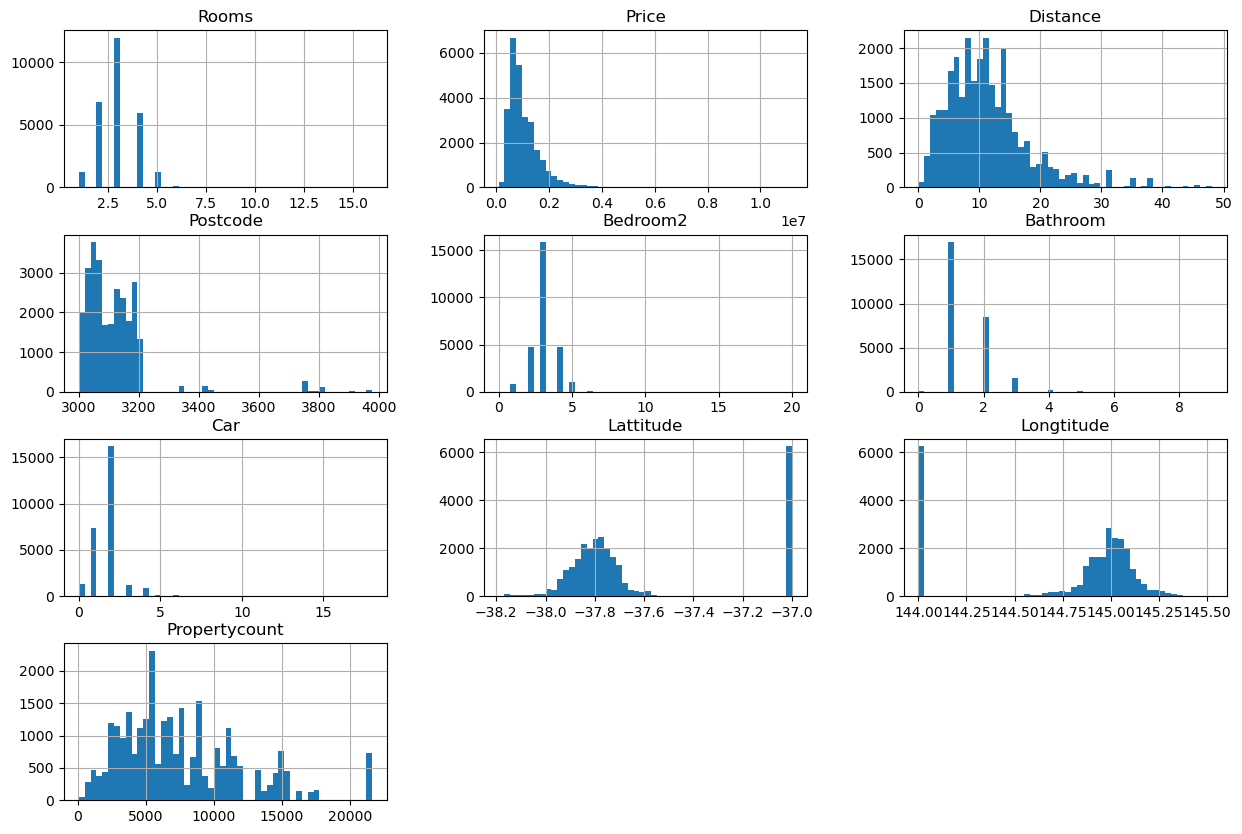

In [6]:
housingcopy.hist(bins=50, figsize=(15, 10))
plt.show()

Right now the histograms have looked a bit different. We will address other notable issues: skew and outliers. We can see that Price and Distance simply have very long right tails (skew) while Rooms, Postcode, Bedroom2, Bathroom and Car have many outliers. To address skew distributions, we can use log, for outliers we can remove or cap them.

Skewness is a measure of the asymmetry of a distribution, or how much the distribution deviates from a normal distribution. A skewed distribution can affect the performance of machine learning models, especially those that assume a normal distribution or have sensitivity to outliers.

In [7]:
# calculate skewness of each column in the DataFrame
skewness = housingcopy.skew()

# print the skewness values
print(skewness)

Rooms            0.511276
Price            2.588969
Distance         1.478797
Postcode         3.981854
Bedroom2         0.909076
Bathroom         1.639065
Car              1.598751
Lattitude        1.095955
Longtitude      -1.082893
Propertycount    1.016217
dtype: float64


/var/folders/kf/5_ggvsz93vxdbx_h0tvy66xh0000gn/T/ipykernel_10575/18523924.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewness = housingcopy.skew()


We are going to address skewness of Price and Distance by adding log of them. We are not going to address the skewness of Postcode despite it being large. For other attributes, we would handle outliers by capping them.

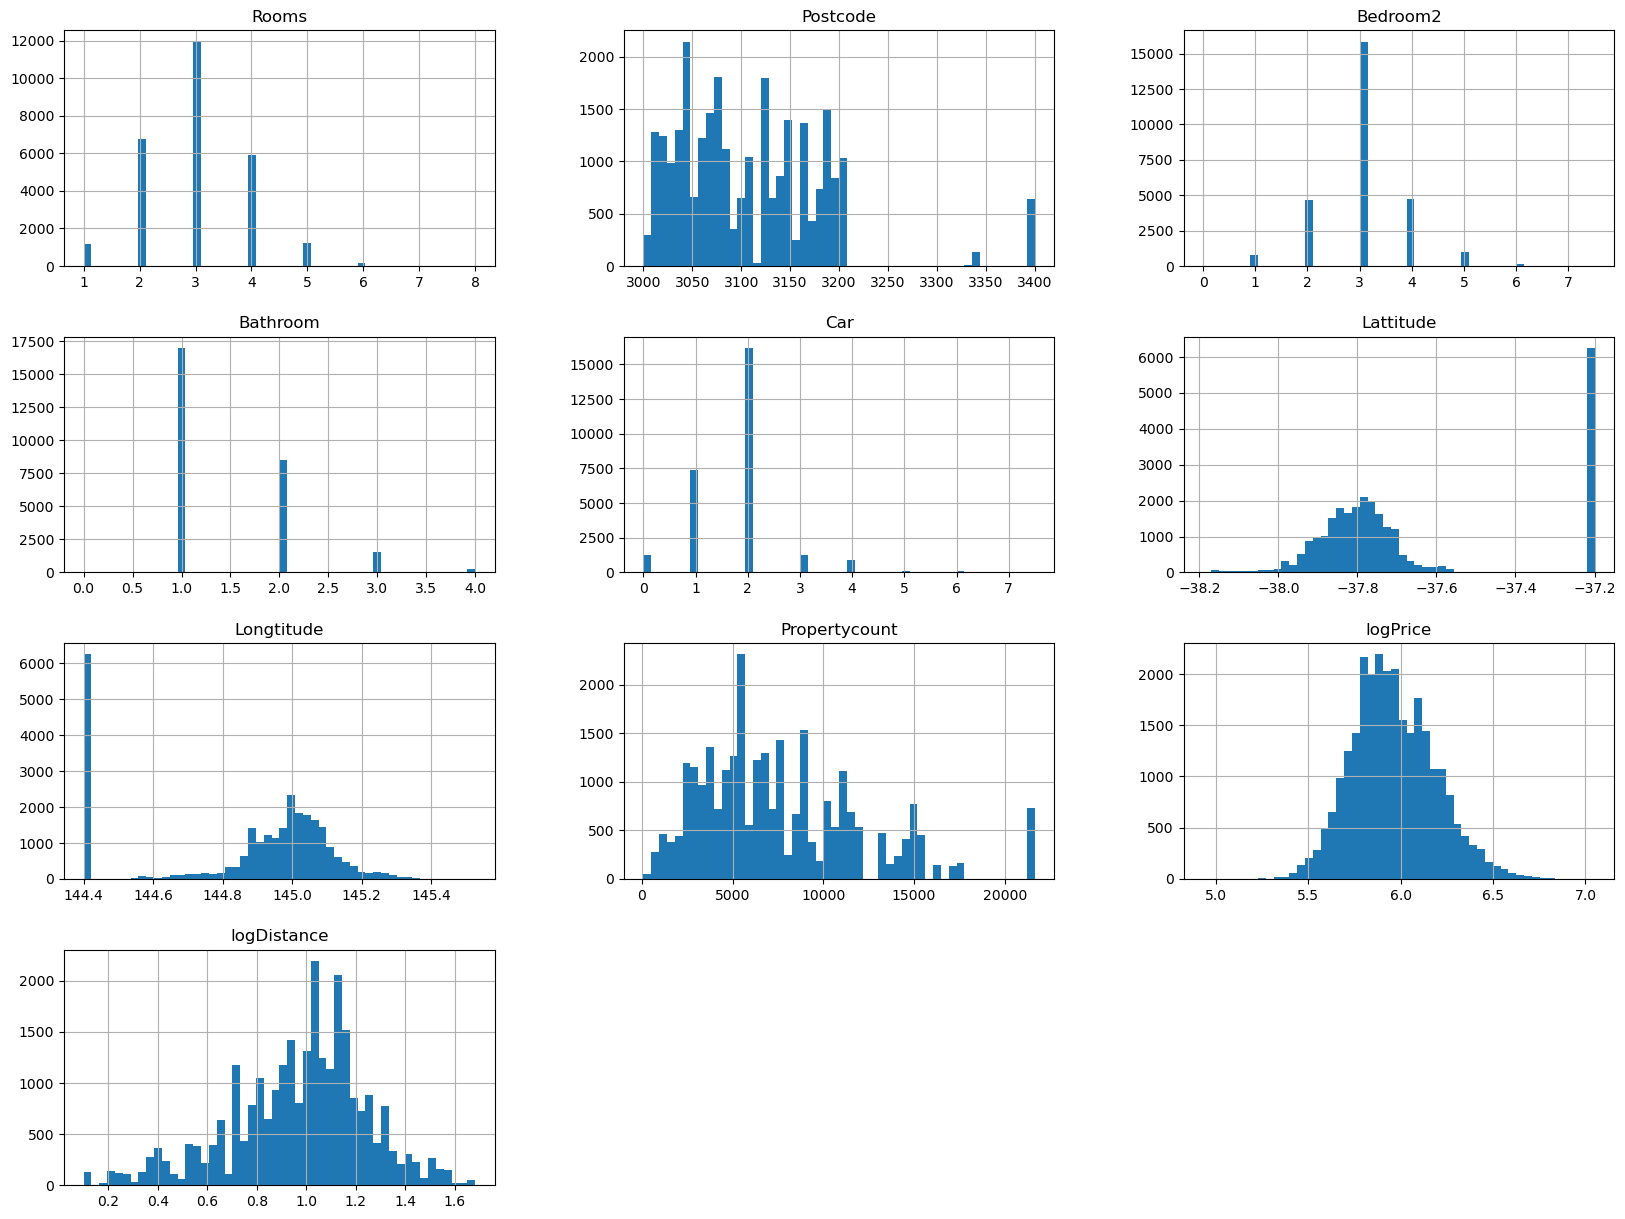

In [10]:
minDistance=0.1
housingcopy['Distance']=housingcopy['Distance'].where(housingcopy['Distance']>=0.1,0.1)
maxRooms = 8
housingcopy['Rooms']=housingcopy['Rooms'].where(housingcopy['Rooms'] <= maxRooms, maxRooms)      
maxPostcode=3400
housingcopy['Postcode']=housingcopy['Postcode'].where(housingcopy['Postcode'] <= maxPostcode, maxPostcode)
maxBedroom2=7.5
housingcopy['Bedroom2']=housingcopy['Bedroom2'].where(housingcopy['Bedroom2'] <= maxBedroom2, maxBedroom2)
maxBathroom=4
housingcopy['Bathroom']=housingcopy['Bathroom'].where(housingcopy['Bathroom'] <= maxBathroom, maxBathroom)
maxCar=7.5
housingcopy['Car']=housingcopy['Car'].where(housingcopy['Car'] <= maxCar, maxCar)
maxLattitude=-37.2
housingcopy['Lattitude']=housingcopy['Lattitude'].where(housingcopy['Lattitude'] <= maxLattitude, maxLattitude)
minLongtitude=144.4
housingcopy['Longtitude']=housingcopy['Longtitude'].where(housingcopy['Longtitude'] >= minLongtitude, minLongtitude)

housingcopy['logPrice'] = np.log10(housingcopy['Price'])
housingcopy['logDistance'] = np.log10(housingcopy['Distance'])
minlogDistance=0.1
housingcopy['logDistance']=housingcopy['logDistance'].where(housingcopy['logDistance'] >= minlogDistance, minlogDistance)

housingcopy=housingcopy.drop(['Price', 'Distance'], axis=1)


housingcopy.hist(bins=50, figsize=(20, 15))
plt.show()

Voila! The histograms have looked much better.

## Feature engineering
To see if we can combine variables into new attributes, we first look at the correlation among them:

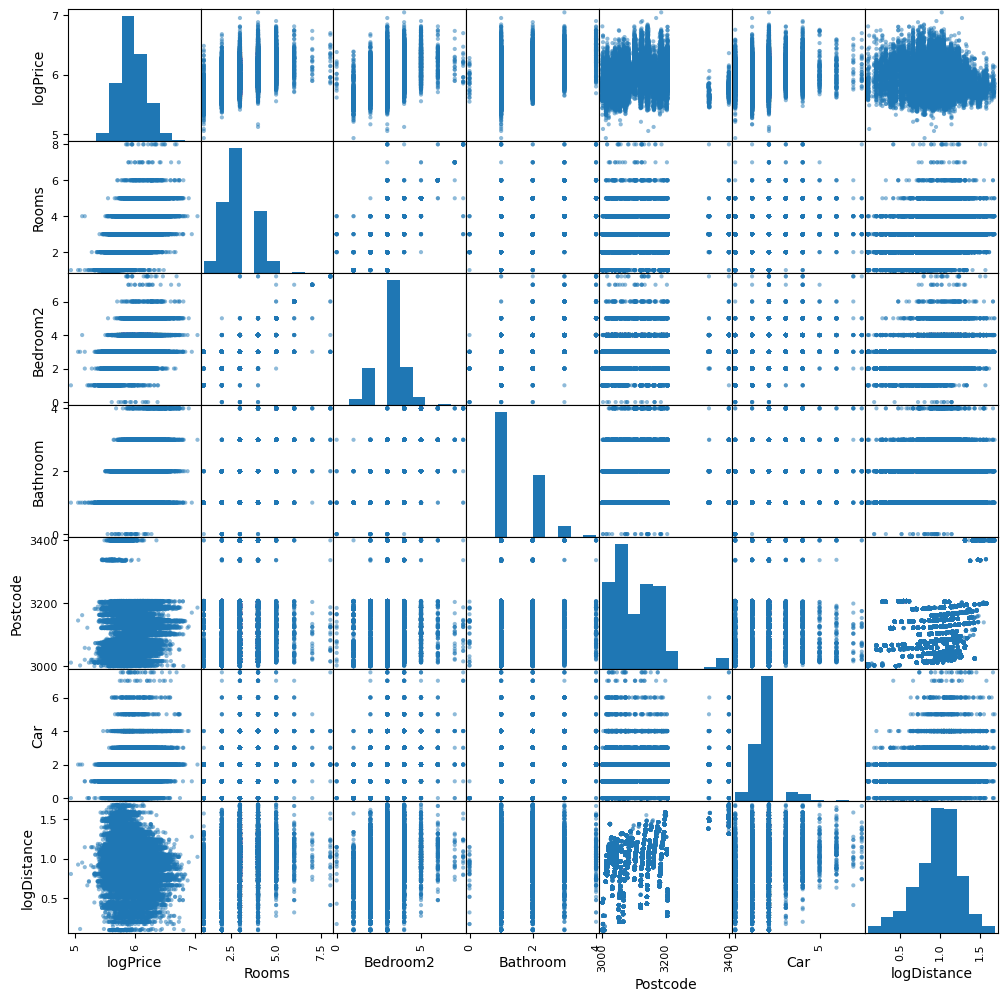

In [11]:
from pandas.plotting import scatter_matrix
attributes = ["logPrice", "Rooms", "Bedroom2",
              "Bathroom","Postcode","Car","logDistance"]
scatter_matrix(housingcopy[attributes], figsize=(12, 12))
plt.show()

In [12]:
corr_matrix = housingcopy.corr()
corr_matrix["logPrice"].sort_values(ascending=False)

logPrice         1.000000
Rooms            0.529889
Bedroom2         0.428506
Bathroom         0.391019
Longtitude       0.212303
Car              0.171917
Postcode         0.110744
Propertycount   -0.085084
logDistance     -0.162746
Lattitude       -0.193534
Name: logPrice, dtype: float64



It seems that the price is most related to the number of rooms, we can combine the number of bedroom and bathroom to have a new variable: total_restrooms


In [13]:
housingcopy['total_restrooms']=housingcopy['Bedroom2']+housingcopy['Bathroom']

In [14]:
corr_matrix = housingcopy.corr()
corr_matrix["logPrice"].sort_values(ascending=False)

logPrice           1.000000
Rooms              0.529889
total_restrooms    0.464473
Bedroom2           0.428506
Bathroom           0.391019
Longtitude         0.212303
Car                0.171917
Postcode           0.110744
Propertycount     -0.085084
logDistance       -0.162746
Lattitude         -0.193534
Name: logPrice, dtype: float64

Together, the number of restrooms is more correlated to logPrice than each of them, so we can drop the number of bedrooms and bathrooms and use the number of rest rooms variable instead.

## Categorical variable encoding
There are different ways to encode categorical variables into numerical variables: label encoding, one hot encoding, and the like. In label encoding, we assign a unique integer or ordinal number to each category, based on their order or frequency. This method works well for categorical variables that have a natural order or hierarchy, such as education level or income bracket. However, it may not be suitable for variables that have no inherent order, such as colors or brands. In one-hot encoding, we create a binary vector or matrix for each category, where each element represents the presence or absence of the category. This method works well for categorical variables that have no order or hierarchy, and can handle multiple categories for each observation. However, it may create a large number of features or variables, and can lead to overfitting or sparsity issues.

In [ ]:
housingcopy.info()

Looking into those categorical variables, we will drop Address, SellerG, Date and would use one hot encoding for the rest since those variables are not hierarchical (living in one region is not inherently superior than another region).

In [16]:
housing_cat=housingcopy.select_dtypes(include=[np.object])
housing_cat=housing_cat.drop(['Address','SellerG','Date'],axis=1)
housing_cat

/var/folders/kf/5_ggvsz93vxdbx_h0tvy66xh0000gn/T/ipykernel_10575/894280556.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  housing_cat=housingcopy.select_dtypes(include=[np.object])


,Suburb,Type,Method,CouncilArea,Regionname
1,Abbotsford,h,S,Yarra City Council,Northern Metropolitan
2,Abbotsford,h,S,Yarra City Council,Northern Metropolitan
4,Abbotsford,h,SP,Yarra City Council,Northern Metropolitan
5,Abbotsford,h,PI,Yarra City Council,Northern Metropolitan
6,Abbotsford,h,VB,Yarra City Council,Northern Metropolitan
...,...,...,...,...,...
34852,Yarraville,h,PI,Maribyrnong City Council,Western Metropolitan
34853,Yarraville,h,SP,Maribyrnong City Council,Western Metropolitan
34854,Yarraville,t,S,Maribyrnong City Council,Western Metropolitan
34855,Yarraville,h,SP,Maribyrnong City Council,Western Metropolitan


In [17]:
np.set_printoptions(suppress=True)

In [68]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot=pd.DataFrame.sparse.from_spmatrix(housing_cat_1hot)
housing_cat_1hot.columns=cat_encoder.get_feature_names_out()
housing_cat_1hot = housing_cat_1hot.reindex(range(1,len(housing_cat_1hot)+1))
from sklearn.impute import SimpleImputer
modeimputer=SimpleImputer(strategy="most_frequent")
modeimputer.fit(housing_cat_1hot)
housing_cat_1hot=modeimputer.transform(housing_cat_1hot)
housing_cat_1hot=pd.DataFrame.sparse.from_spmatrix(housing_cat_1hot)
housing_cat_1hot.columns=cat_encoder.get_feature_names_out()


housing_cat_1hot

,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,Suburb_Albion,Suburb_Alphington,Suburb_Altona,Suburb_Altona Meadows,Suburb_Altona North,...,CouncilArea_nan,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,Regionname_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0



## Normalize

After encoding the categorical variables, let's normalize the numerical attributes. The goal of normalization is to scale the values of different features or variables to a common range, so that they have similar magnitudes and are not dominated by one feature. We can use techniques like standardization (subtracting the mean and dividing by the standard deviation) or min-max scaling (scaling the values to a range between 0 and 1). We will use the standardization technique.

In [24]:
housing_num=housingcopy.select_dtypes(include=[np.number])
housing_num

,Rooms,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Propertycount,logPrice,logDistance,total_restrooms
1,2,3067.0,2.0,1.0,1.0,-37.79960,144.99840,4019.0,6.170262,0.397940,3.0
2,2,3067.0,2.0,1.0,0.0,-37.80790,144.99340,4019.0,6.014940,0.397940,3.0
4,3,3067.0,3.0,2.0,0.0,-37.80930,144.99440,4019.0,6.165838,0.397940,5.0
5,3,3067.0,3.0,2.0,1.0,-37.79690,144.99690,4019.0,5.929419,0.397940,5.0
6,4,3067.0,3.0,1.0,2.0,-37.80720,144.99410,4019.0,6.204120,0.397940,4.0
...,...,...,...,...,...,...,...,...,...,...,...
34852,4,3013.0,4.0,1.0,3.0,-37.81053,144.88467,6543.0,6.170262,0.799341,5.0
34853,2,3013.0,2.0,2.0,1.0,-37.81551,144.88826,6543.0,5.948413,0.799341,4.0
34854,2,3013.0,2.0,1.0,2.0,-37.82286,144.87856,6543.0,5.848189,0.799341,3.0
34855,3,3013.0,3.0,1.0,2.0,-37.20000,144.40000,6543.0,6.056905,0.799341,4.0


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(housing_num)
scaled_num = pd.DataFrame(scaled,index=housing_num.index,columns=housing_num.columns)
scaled_num.head()

,Rooms,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Propertycount,logPrice,logDistance,total_restrooms
1,-1.046448,-0.52353,-1.260957,-0.696023,-0.916577,-0.493070,0.509046,-0.789709,0.937812,-2.094451,-1.141261
2,-1.046448,-0.52353,-1.260957,-0.696023,-2.083830,-0.524085,0.490689,-0.789709,0.245997,-2.094451,-1.141261
4,0.009182,-0.52353,-0.041078,0.856158,-2.083830,-0.529316,0.494360,-0.789709,0.918107,-2.094451,0.398809
5,0.009182,-0.52353,-0.041078,0.856158,-0.916577,-0.482981,0.503539,-0.789709,-0.134922,-2.094451,0.398809
6,1.064812,-0.52353,-0.041078,-0.696023,0.250676,-0.521469,0.493259,-0.789709,1.088619,-2.094451,-0.371226


In [26]:
scaled_num=scaled_num.reindex(range(1,len(scaled_num)+1))
scaled_num

,Rooms,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Propertycount,logPrice,logDistance,total_restrooms
1,-1.046448,-0.523530,-1.260957,-0.696023,-0.916577,-0.493070,0.509046,-0.789709,0.937812,-2.094451,-1.141261
2,-1.046448,-0.523530,-1.260957,-0.696023,-2.083830,-0.524085,0.490689,-0.789709,0.245997,-2.094451,-1.141261
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.009182,-0.523530,-0.041078,0.856158,-2.083830,-0.529316,0.494360,-0.789709,0.918107,-2.094451,0.398809
5,0.009182,-0.523530,-0.041078,0.856158,-0.916577,-0.482981,0.503539,-0.789709,-0.134922,-2.094451,0.398809
...,...,...,...,...,...,...,...,...,...,...,...
27243,0.009182,-0.823824,-0.041078,0.856158,1.417930,-0.240095,0.309322,-0.018541,-0.013639,-0.161467,0.398809
27244,0.009182,-0.823824,-0.041078,-0.696023,0.250676,1.747460,-1.687915,-0.018541,-0.276526,-0.161467,-0.371226
27245,0.009182,-0.823824,-0.041078,-0.696023,0.250676,1.747460,-1.687915,-0.018541,0.100486,-0.161467,-0.371226
27246,0.009182,-0.823824,-0.041078,-0.696023,0.250676,1.747460,-1.687915,-0.018541,-0.228164,-0.161467,-0.371226


In [27]:
meanimputer = SimpleImputer(strategy="mean")
meanimputer.fit(scaled_num)

scaled_num2=meanimputer.transform(scaled_num)
scaled_num2=pd.DataFrame(scaled_num2,columns=scaled_num.columns)
scaled_num2

,Rooms,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Propertycount,logPrice,logDistance,total_restrooms
0,-1.046448,-0.523530,-1.260957,-0.696023,-0.916577,-0.493070,0.509046,-0.789709,0.937812,-2.094451,-1.141261
1,-1.046448,-0.523530,-1.260957,-0.696023,-2.083830,-0.524085,0.490689,-0.789709,0.245997,-2.094451,-1.141261
2,-0.031743,-0.029750,-0.069013,-0.004629,-0.067320,-0.086359,0.077531,-0.010363,0.007633,-0.059730,-0.045860
3,0.009182,-0.523530,-0.041078,0.856158,-2.083830,-0.529316,0.494360,-0.789709,0.918107,-2.094451,0.398809
4,0.009182,-0.523530,-0.041078,0.856158,-0.916577,-0.482981,0.503539,-0.789709,-0.134922,-2.094451,0.398809
...,...,...,...,...,...,...,...,...,...,...,...
27242,0.009182,-0.823824,-0.041078,0.856158,1.417930,-0.240095,0.309322,-0.018541,-0.013639,-0.161467,0.398809
27243,0.009182,-0.823824,-0.041078,-0.696023,0.250676,1.747460,-1.687915,-0.018541,-0.276526,-0.161467,-0.371226
27244,0.009182,-0.823824,-0.041078,-0.696023,0.250676,1.747460,-1.687915,-0.018541,0.100486,-0.161467,-0.371226
27245,0.009182,-0.823824,-0.041078,-0.696023,0.250676,1.747460,-1.687915,-0.018541,-0.228164,-0.161467,-0.371226


After preprocessing numerical and categorical variables, we concatenate them into one dataframe:

In [36]:
result = pd.concat([scaled_num2, housing_cat_1hot], axis=1, join='inner')
result.shape
result

,Rooms,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Propertycount,logPrice,logDistance,...,CouncilArea_nan,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,Regionname_nan
0,-1.046448,-0.523530,-1.260957,-0.696023,-0.916577,-0.493070,0.509046,-0.789709,0.937812,-2.094451,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.046448,-0.523530,-1.260957,-0.696023,-2.083830,-0.524085,0.490689,-0.789709,0.245997,-2.094451,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.031743,-0.029750,-0.069013,-0.004629,-0.067320,-0.086359,0.077531,-0.010363,0.007633,-0.059730,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.009182,-0.523530,-0.041078,0.856158,-2.083830,-0.529316,0.494360,-0.789709,0.918107,-2.094451,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.009182,-0.523530,-0.041078,0.856158,-0.916577,-0.482981,0.503539,-0.789709,-0.134922,-2.094451,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27242,0.009182,-0.823824,-0.041078,0.856158,1.417930,-0.240095,0.309322,-0.018541,-0.013639,-0.161467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27243,0.009182,-0.823824,-0.041078,-0.696023,0.250676,1.747460,-1.687915,-0.018541,-0.276526,-0.161467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27244,0.009182,-0.823824,-0.041078,-0.696023,0.250676,1.747460,-1.687915,-0.018541,0.100486,-0.161467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27245,0.009182,-0.823824,-0.041078,-0.696023,0.250676,1.747460,-1.687915,-0.018541,-0.228164,-0.161467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0



# EDA

If we plot the data by longitude and latitude with respect to the price, we can see that the houses are clustered in the middle and has the highest price there. Going from the center, the price seems to increase in the southeast part of melbourne, with the price in the northwest part mostly the same. This pattern shows up in the log price scatter plot too.

<AxesSubplot:xlabel='Longtitude', ylabel='Lattitude'>

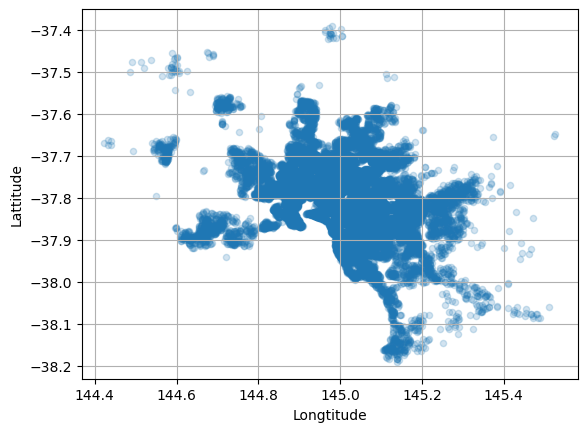

In [32]:
housing.plot(kind="scatter", x="Longtitude", y="Lattitude", grid=True,alpha=0.2)

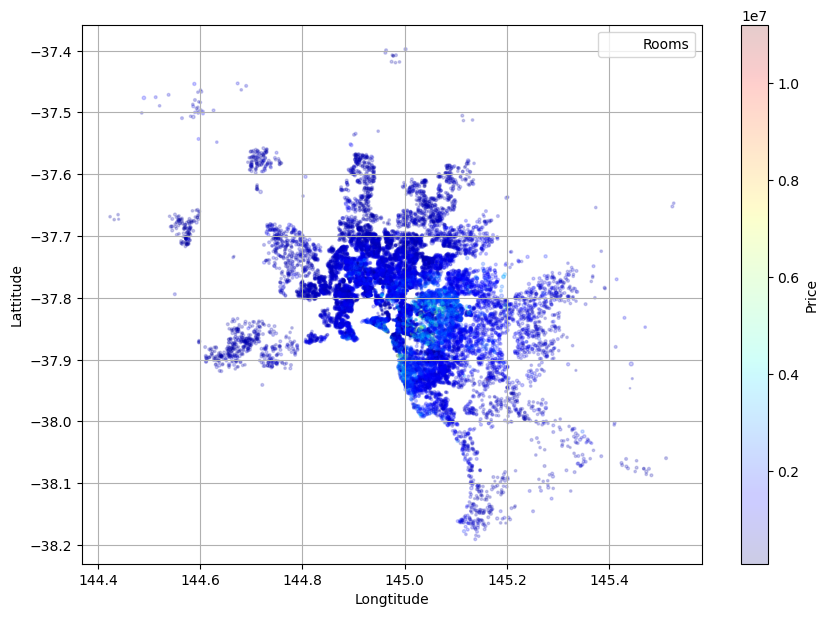

In [75]:
housing.plot(kind="scatter", x="Longtitude", y="Lattitude", grid=True,alpha=0.2,
             s=housing["Rooms"], label="Rooms",
             c="Price", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

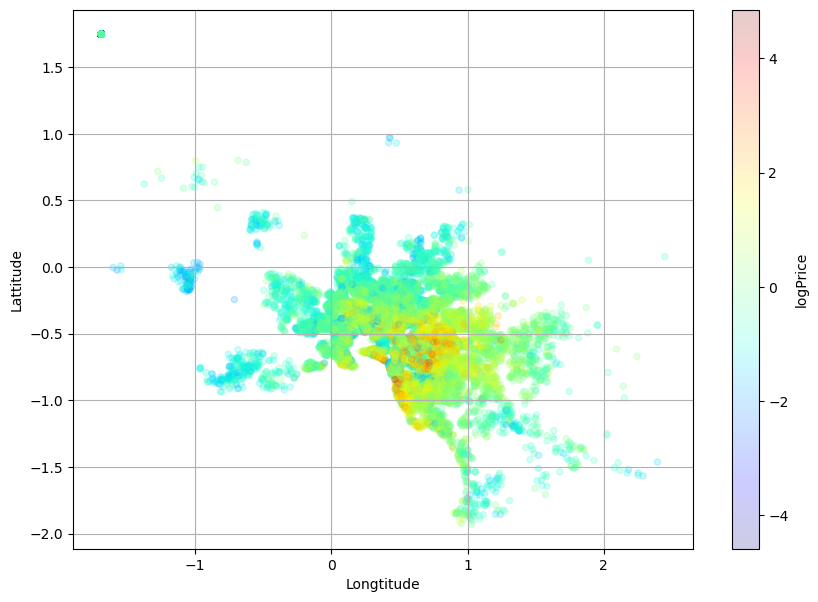

In [78]:
result.plot(kind="scatter", x="Longtitude", y="Lattitude", grid=True,alpha=0.2,
#              s=housing["Rooms"], label="Rooms",
             c="logPrice", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

# Training
## Linear Regression with regularization
Linear regression is a simple yet powerful method that helps to model the relationship between a dependent variable and one or more independent variables. We would run a linear regression and then add some regularization. Regularization usually helps the model to cut down on overfitting, and in general it generalizes better, hence improve the performance of the model.

There are two main types of regularization: L1 regularization and L2 regularization. L1 regularization, also known as Lasso regularization, adds a penalty term proportional to the absolute value of the model coefficients. This results in sparse models, where some of the coefficients are set to zero, effectively removing some of the features from the model. 

Lasso (least absolute shrinkage and selection operator) adds the absolute form on constraint ($$ \alpha \sum_{j=1}^{p} \mid \theta_{j} \mid $$) to the parameters $$ \theta $$ in the loss function:

$$ Loss = \sum_{i=1}^{n}(y_i - \sum_{j=1}^{p} x_{ij} \theta_j)^2 + \alpha \sum_{j=1}^{p} \mid \theta_{j} \mid $$

L2 regularization, also known as Ridge regularization, adds a penalty term proportional to the squared magnitude of the model coefficients. This results in models with smaller coefficients and smoother decision boundaries since it punish too big or too small parameters.

Ridge Regression adds a squared form of constraint ($$ \alpha \sum_{j=1}^{p} \theta_{j}^{2} $$) on the parameter $$ \theta $$ in the loss function:

$$ Loss = \sum_{i=1}^{n}(y_i - \sum_{j=1}^{p} x_{ij} \theta_j)^2 + \alpha \sum_{j=1}^{p} \theta_{j}^{2} $$

Elastic Net is a regularization technique used in linear regression models that combines the strengths of both L1 (Lasso) and L2 (Ridge) regularization. Elastic Net adds a penalty term to the loss function of the model that is a weighted combination of the L1 and L2 penalties. The weight of each penalty is controlled by a hyperparameter that determines the strength of the regularization.

The elastic net penalty term encourages the model to learn sparse representations, similar to L1 regularization, while also ensuring that correlated features are shrunk together, similar to L2 regularization. This makes it a particularly effective technique for dealing with high-dimensional datasets with correlated features, where L1 and L2 regularization alone may not be sufficient.

Here is the elatic net term:

$$ Loss = \sum_{i=1}^{n}(y_i - \sum_{j=1}^{p} x_{ij} \theta_j)^2 + \alpha \sum_{j=1}^{p} \theta_{j}^{2} + + \beta \sum_{j=1}^{p} \mid \theta_{j} \mid $$ with the hyperparameters $$ \alpha $$ and $$ \beta $$ to balance between L1 loss and L2 loss.

In our example, Ridge gives us the best root mean squared error on the test set (0.196)

In [51]:
y=housingcopy['logPrice']

In [53]:
X= np.array(result)
y=np.array(y)

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error


In [95]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
lin_rmse = mean_squared_error(y_test, y_pred,
                               squared=False)

lin_rmse

6923604520.172732

In [94]:
clf = Lasso(alpha=0.1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
lin_rmse = mean_squared_error(y_test, y_pred,
                               squared=False)

lin_rmse

0.2233975109057049

In [91]:
clf2 = Ridge(alpha=1.0)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
lin_rmse = mean_squared_error(y_test, y_pred,
                               squared=False)

lin_rmse

0.196456119297143

In [93]:
regr = ElasticNet(random_state=0)
regr.fit(X_train, y_train)
y_pred=regr.predict(X_test)
lin_rmse = mean_squared_error(y_test, y_pred,
                               squared=False)

lin_rmse

0.2233975109057049

## K fold cross validation
For example, a 10-fold cross validation method will split the dataset into 10 non overlapping subsets called folds. Each time it uses one fold: training on 9 folds and evaluating on the last fold. The scores (mean squared error) are 10 scores from 10 training times. We use Ridge regression, Decision Tree and Random Forest, Ridge again achieves the best score (lowest) of 0.19. RandomForest is a bit worse at 0.2, and Decision Tree is around 0.27.

In [98]:
from sklearn.model_selection import cross_val_score
lin_rmses = -cross_val_score(clf2, X_train, y_train,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_rmses

array([0.19274845, 0.19486979, 0.1949542 , 0.19586131, 0.19846673,
       0.19671158, 0.19747097, 0.1977136 , 0.20391569, 0.19843234])

In [61]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
tree_rmse = mean_squared_error(y_test, y_pred,
                                squared=False)

tree_rmse


0.2700937748340098

In [62]:
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg, X_train, y_train,
                              scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([0.26613102, 0.26311385, 0.26655769, 0.26467363, 0.26733308,
       0.27428677, 0.26872589, 0.27553391, 0.26702197, 0.2702954 ])

In [63]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_rmses = -cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_root_mean_squared_error", cv=10)
forest_rmses

array([0.20237999, 0.20497054, 0.20594208, 0.20602234, 0.20787097,
       0.20677218, 0.20866224, 0.21074428, 0.21268268, 0.21056594])

## Grid Search
A grid search allows you to fine tune the hyper parameters with a provided array (grid) of them. There is grid search and randomized search. Randomized search is when you give the range of the hyper parameters and the machine would choose randomly in the process. Since we get good result with Ridge regression, we continue to search for the best hyperparameter for it. The result is that the best alpha for ridge is 3 and the mean squared error reduces from 0.1965 to 0.1964.

In [104]:
grid_space={'alpha':[0.5,1,3,10]
           }
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(clf2,param_grid=grid_space,cv=3,scoring='neg_root_mean_squared_error')
model_grid = grid.fit(X_train,y_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'alpha': 3}
Best score is: -0.19693259524684636


In [106]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {'alpha': randint(low=1, high=50),}
rnd_search = RandomizedSearchCV(
    clf2, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'alpha': 3}
Best score is: -0.19693259524684636


In [107]:
clf2 = Ridge(alpha=3)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
lin_rmse = mean_squared_error(y_test, y_pred,
                               squared=False)

lin_rmse

0.19635727066256592

# Monitor

There is one approach to monitor for anomalies in housing price in Melbourne, so that people are not ripped off. Since we have a nice distribution of log price, we will consider something above or below 5 standard deviations from the mean to be outlier. We can print out the outliers and notify the admin if necessary.


<AxesSubplot:>

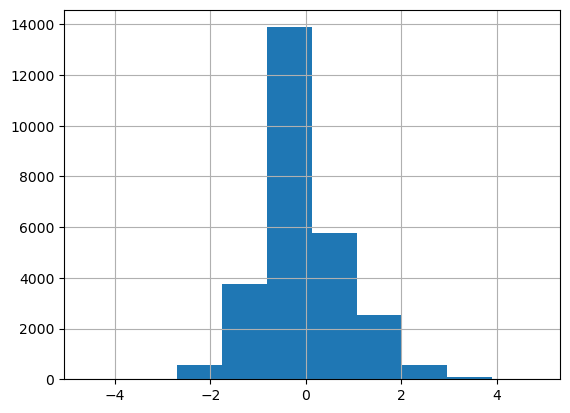

In [116]:
result['logPrice'].hist()

In [109]:
result['logPrice'].skew()

0.33355745693169997

In [110]:
result['logPrice'].describe()

count    27247.000000
mean         0.007633
std          0.893743
min         -4.589008
25%         -0.510495
50%          0.007633
75%          0.483157
max          4.852758
Name: logPrice, dtype: float64

In [117]:
print("Upper limit",result['logPrice'].mean() + 5*result['logPrice'].std())
print("Lower limit",result['logPrice'].mean() - 5*result['logPrice'].std())

Upper limit 4.476346245938641
Lower limit -4.461080863899662


In [118]:
result[(result['logPrice'] > 4.48) | (result['logPrice'] < -4.46)]


,Rooms,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Propertycount,logPrice,logDistance,...,CouncilArea_nan,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,Regionname_nan
4377,-2.102077,-1.254681,-2.480836,-0.696023,-2.083830,-0.461308,0.111067,0.000371,-4.589008,-0.609686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25634,1.064812,1.030168,1.178802,2.408339,0.250676,-0.843387,0.465099,0.669859,4.852758,0.172301,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [127]:
housing=housing.reindex(range(0,len(scaled_num)))

In [128]:
housing.iloc[4377]

Suburb                          Footscray
Address                  4/33 Ballarat Rd
Rooms                                   3
Type                                    t
Price                            585000.0
Method                                  S
SellerG                            Nelson
Date                            3/09/2016
Distance                              6.4
Postcode                           3011.0
Bedroom2                              3.0
Bathroom                              1.0
Car                                   1.0
Landsize                            259.0
BuildingArea                          NaN
YearBuilt                             NaN
CouncilArea      Maribyrnong City Council
Lattitude                        -37.7955
Longtitude                       144.9063
Regionname           Western Metropolitan
Propertycount                      7570.0
Name: 4377, dtype: object

In [129]:
housing.iloc[25634]

Suburb                        Brighton
Address                 78 Champion St
Rooms                                3
Type                                 h
Price                        2040000.0
Method                               S
SellerG                       Marshall
Date                        28/10/2017
Distance                          10.5
Postcode                        3186.0
Bedroom2                           3.0
Bathroom                           3.0
Car                                2.0
Landsize                         446.0
BuildingArea                       NaN
YearBuilt                          NaN
CouncilArea       Bayside City Council
Lattitude                     -37.9213
Longtitude                   145.00454
Regionname       Southern Metropolitan
Propertycount                  10579.0
Name: 25634, dtype: object